In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        
        should_get_same_class = random.randint(0,1) 
        
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.tensor(not should_get_same_class, dtype=torch.float32)
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
# !wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
# !unzip "at&t.zip"

In [6]:
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [7]:
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

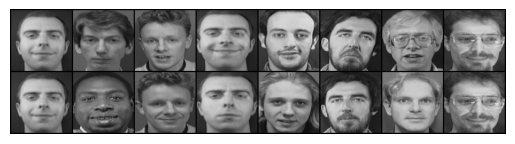

[0. 1. 0. 0. 1. 0. 1. 0.]


In [8]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,
                        num_workers=1,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [9]:
example_batch[0].shape

torch.Size([8, 1, 100, 100])

In [10]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [11]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidian distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive


In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=512)

In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 2.0198028087615967

Epoch number 1
 Current loss 2.0010485649108887

Epoch number 2
 Current loss 1.9846752882003784

Epoch number 3
 Current loss 1.8071602582931519

Epoch number 4
 Current loss 1.7955549955368042

Epoch number 5
 Current loss 1.6583234071731567

Epoch number 6
 Current loss 1.5114020109176636

Epoch number 7
 Current loss 1.8506954908370972

Epoch number 8
 Current loss 1.6059046983718872

Epoch number 9
 Current loss 1.5816432237625122

Epoch number 10
 Current loss 1.6004059314727783

Epoch number 11
 Current loss 1.5526928901672363

Epoch number 12
 Current loss 1.6276189088821411

Epoch number 13
 Current loss 1.5240905284881592

Epoch number 14
 Current loss 1.6914780139923096

Epoch number 15
 Current loss 1.501895546913147

Epoch number 16
 Current loss 1.4884918928146362

Epoch number 17
 Current loss 1.4803755283355713

Epoch number 18
 Current loss 1.4120724201202393

Epoch number 19
 Current loss 1.447105050086975

Epoch number

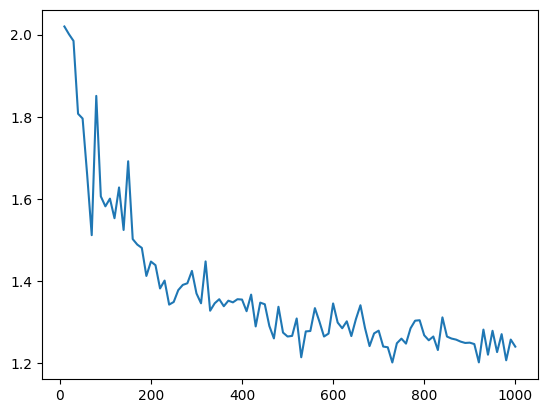

In [14]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()
        
        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)
     